# Hyperopt-sklearn using TPE for Random Forest classifier

## Import the dependencies

In [1]:
from hpsklearn import HyperoptEstimator, random_forest, one_hot_encoder, any_preprocessing
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.display import Image
from sklearn.tree import export_graphviz
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pydot
import pickle
import warnings
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, rand
import hyperopt
plt.set_cmap("viridis")
warnings.filterwarnings("ignore")

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


# Dataset 1

## Load data

Link to data set: https://archive.ics.uci.edu/ml/datasets/Chess+%28King-Rook+vs.+King-Pawn%29

Chess End-Game -- King+Rook versus King+Pawn on a7 (usually abbreviated KRKPA7). The pawn on a7 means it is one square away from queening.  It is the King+Rook's side (white) to move.

Feature description can be found here: http://notolog.blogspot.com/2011/01/features-of-uci-chess-data-sets.html

In [89]:
data = pd.read_csv("kr-vs-kp.data")
data.head()

,f,f.1,f.2,f.3,f.4,f.5,f.6,f.7,f.8,f.9,...,f.23,f.24,f.25,f.26,f.27,f.28,t.2,t.3,n.1,won
0,f,f,f,f,t,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
1,f,f,f,f,t,f,t,f,f,f,...,f,f,f,f,f,f,t,t,n,won
2,f,f,f,f,f,f,f,f,t,f,...,f,f,f,f,f,f,t,t,n,won
3,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
4,f,f,f,f,f,f,f,f,f,f,...,f,f,t,f,f,f,t,t,n,won


In [3]:
print(data.shape)

(3195, 37)


In [77]:
data.describe()

,f,f.1,f.2,f.3,f.4,f.5,f.6,f.7,f.8,f.9,...,f.23,f.24,f.25,f.26,f.27,f.28,t.2,t.3,n.1,won
count,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,...,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
freq,2838,2970,3075,2873,2128,1721,2025,2499,1979,2224,...,3194,3148,3059,2630,3020,1983,2006,2344,2406,1668


In [90]:
X = data.loc[:, :'n.1']
y = data.loc[:, 'won']

In [91]:
n_features = X.shape[1]

### Preprocessing of categorical columns

In [92]:
le = LabelEncoder()
X = X.apply(lambda col: le.fit_transform(col))
y = le.fit_transform(y)

### Make train and test subsets

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)

## Set number of iterations

In [94]:
n_iter_search = 10

## Appy HyperoptEstimator with Random Forest Classificator

## TPE

#### Run with specified bounds

In [95]:
params = {"min_samples_split": hp.choice('min_samples_split', np.arange(2, 1000, dtype=int)),
              "min_samples_leaf": hp.choice('min_samples_leaf', np.arange(1, 1000, dtype=int)),
              "bootstrap": hp.choice('bootstrap', [True, False]),
              "criterion": hp.choice('criterion', ["gini", "entropy"]),
               "n_estimators": hp.choice('n_estimators', np.arange(1, 3000, dtype=int))}

In [176]:
estim = HyperoptEstimator(classifier=random_forest('myRF', 
                                                  min_samples_split=params['min_samples_split'],
                                                  min_samples_leaf=params['min_samples_leaf'],
                                                  bootstrap=params['bootstrap'],
                                                  criterion=params['criterion'],
                                                  n_estimators=params['n_estimators']), algo=tpe.suggest, max_evals=n_iter_search, seed=42)

In [97]:
# list to store scores over loop evaluations of benchmark
ho_scores = list()

In [181]:
#%%timeit -o #-n 10
estim.fit(X_train, y_train)

print("=====RESULTS======")
ho_score = estim.score(X_test, y_test)
ho_scores.append(ho_score)
print(ho_score)
print(estim.best_model())

100%|██████████| 1/1 [00:01<00:00,  1.62s/it, best loss: 0.10747663551401865]
=====RESULTS======
0.8966824644549763
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=158, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=146, n_jobs=1,
                       oob_score=False, random_state=1, verbose=False,
                       warm_start=False), 'preprocs': (), 'ex_preprocs': ()}


In [99]:
runtime_ho = _

#### Define utils functions to save and read results of runs

In [3]:
def save_res(res, file_name):
    with open(file_name, 'wb') as fp:
        pickle.dump(res, fp)
        
def read_res(file_name):
    with open (file_name, 'rb') as fp:
        return pickle.load(fp)

In [44]:
save_res(ho_scores, 'temp/ho_scores.txt')

In [45]:
ho_scores = read_res('temp/ho_scores.txt')

In [10]:
help(HyperoptEstimator)

Help on class hyperopt_estimator in module hpsklearn.estimator:

class hyperopt_estimator(sklearn.base.BaseEstimator)
 |  hyperopt_estimator(preprocessing=None, ex_preprocs=None, classifier=None, regressor=None, space=None, algo=None, max_evals=10, loss_fn=None, continuous_loss_fn=False, verbose=False, trial_timeout=None, fit_increment=1, fit_increment_dump_filename=None, seed=None, use_partial_fit=False, refit=True)
 |  
 |  Base class for all estimators in scikit-learn
 |  
 |  Notes
 |  -----
 |  All estimators should specify all the parameters that can be set
 |  at the class level in their ``__init__`` as explicit keyword
 |  arguments (no ``*args`` or ``**kwargs``).
 |  
 |  Method resolution order:
 |      hyperopt_estimator
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, preprocessing=None, ex_preprocs=None, classifier=None, regressor=None, space=None, algo=None, max_evals=10, loss_fn=None, continuous_loss_fn=Fal

#### Run without bounds specification

In [100]:
estim_wo_bounds = HyperoptEstimator(classifier=random_forest('myRF'), algo=tpe.suggest, max_evals=n_iter_search, seed=42)

In [101]:
ho_scores_no_bounds = list()

In [102]:
%%timeit -o #-n 10
estim_wo_bounds.fit(X_train, y_train)

print("=====RESULTS======")
ho_score = estim_wo_bounds.score(X_test, y_test)
ho_scores_no_bounds.append(ho_score)
print(ho_score)
print(estim_wo_bounds.best_model())

100%|██████████| 1/1 [00:03<00:00,  3.07s/it, best loss: 0.014018691588784993]
=====RESULTS======
0.9914691943127962
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2117,
                       n_jobs=1, oob_score=False, random_state=4, verbose=False,
                       warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
100%|██████████| 1/1 [00:01<00:00,  1.09s/it, best loss: 0.01869158878504673]
=====RESULTS======
0.9876777251184834
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_i

100%|██████████| 1/1 [00:00<00:00,  6.52it/s, best loss: 0.002336448598130869]
=====RESULTS======
0.9962085308056872
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=0.7186809332088302,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=11, n_jobs=1, oob_score=False,
                       random_state=0, verbose=False, warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(0.0, 1.0)),), 'ex_preprocs': ()}
100%|██████████| 1/1 [00:00<00:00,  7.06it/s, best loss: 0.0]
=====RESULTS======
0.9962085308056872
{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=0.8999482642753622,
                  

<TimeitResult : 30.1 s ± 15.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [103]:
runtime_ho_no_bounds = _

In [46]:
save_res(ho_scores_no_bounds, 'temp/ho_scores_no_bounds.txt')

In [47]:
ho_scores_no_bounds = read_res('temp/ho_scores_no_bounds.txt')

### Visualization of one tree from Random Forest

In [ ]:
tree = estim.best_model()['learner'].estimators_[0]
export_graphviz(tree, out_file = 'temp/tree.dot', rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('temp/tree.dot')
graph.write_png('img/tree_ho.png')

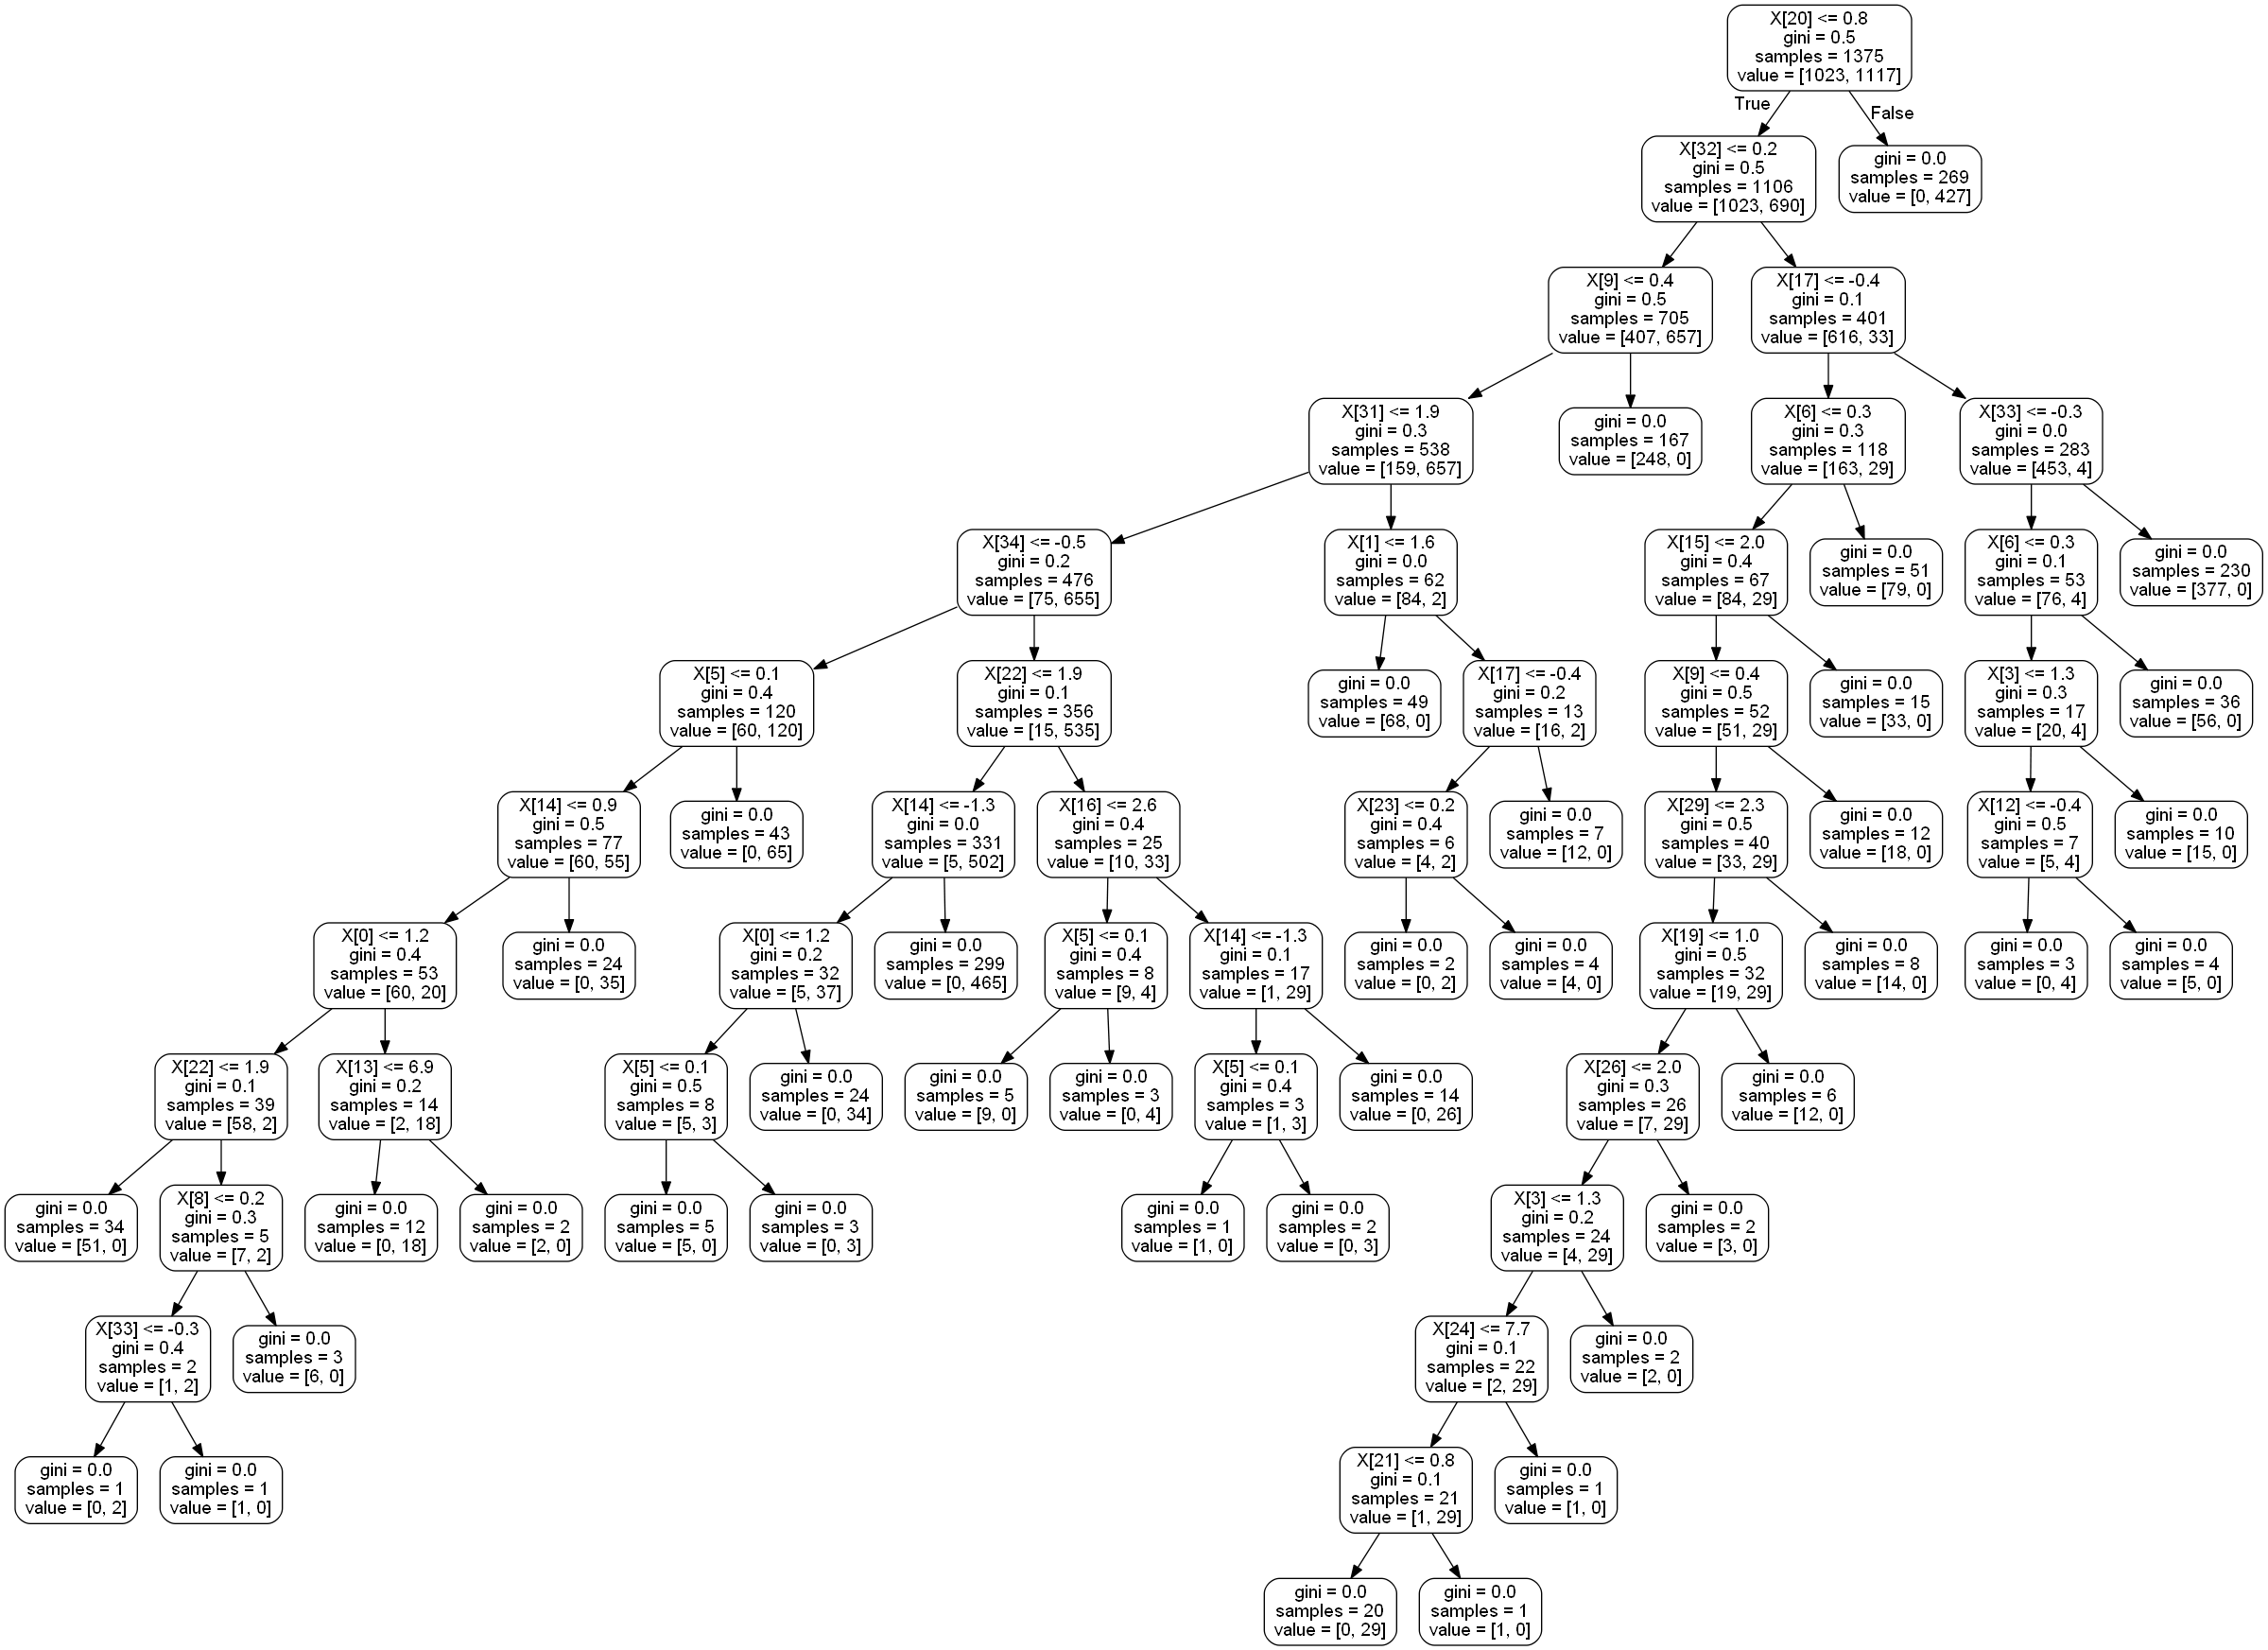

In [91]:
Image("img/tree_ho.png")

## Random Search 

#### Run with specified bounds

In [182]:
estim_rand = HyperoptEstimator(classifier=random_forest('myRF', 
                                                  min_samples_split=params['min_samples_split'],
                                                  min_samples_leaf=params['min_samples_leaf'],
                                                  bootstrap=params['bootstrap'],
                                                  criterion=params['criterion'],
                                                  n_estimators=params['n_estimators']), algo=rand.suggest, max_evals=n_iter_search, seed=42)

In [173]:
ho_scores_rand = list()

In [183]:
#%%timeit -o #-n 10
estim_rand.fit(X_train, y_train)

print("=====RESULTS======")
ho_score = estim_rand.score(X_test, y_test)
ho_scores_rand.append(ho_score)
print(ho_score)
print(estim_rand.best_model())

100%|██████████| 1/1 [00:01<00:00,  1.73s/it, best loss: 0.08878504672897192]
=====RESULTS======
0.9383886255924171
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=3, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=88, min_samples_split=221,
                       min_weight_fraction_leaf=0.0, n_estimators=979, n_jobs=1,
                       oob_score=False, random_state=1, verbose=False,
                       warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(0.0, 1.0)),), 'ex_preprocs': ()}


In [107]:
runtime_estim_rand = _

In [17]:
save_res(ho_scores_rand, 'temp/ho_scores_rand.txt')

In [37]:
ho_scores_rand = read_res('temp/ho_scores_rand.txt')

#### Run without bounds specificaton

In [108]:
estim_rand_wo_bounds = HyperoptEstimator(classifier=random_forest('myRF'), algo=rand.suggest, max_evals=n_iter_search, seed=2)

In [109]:
ho_scores_rand_wo_bounds = list()

In [110]:
%%timeit -o #-n 10
estim_rand_wo_bounds.fit(X_train, y_train)

print("=====RESULTS======")
ho_score = estim_rand_wo_bounds.score(X_test, y_test)
ho_scores_rand_wo_bounds.append(ho_score)
print(ho_score)
print(estim_rand_wo_bounds.best_model())

100%|██████████| 1/1 [00:00<00:00,  6.96it/s, best loss: 0.009345794392523366]
=====RESULTS======
0.995260663507109
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=0.32085523468864874,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=16, n_jobs=1, oob_score=False,
                       random_state=1, verbose=False, warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
100%|██████████| 1/1 [00:00<00:00,  6.87it/s, best loss: 0.002336448598130869]
=====RESULTS======
0.995260663507109
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.6597342900988239,
                       max_leaf_nodes=None, min_impuri

100%|██████████| 1/1 [00:02<00:00,  2.43s/it, best loss: 0.016355140186915862]
=====RESULTS======
0.990521327014218
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
                       oob_score=False, random_state=4, verbose=False,
                       warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
100%|██████████| 1/1 [00:00<00:00,  5.48it/s, best loss: 0.016355140186915862]
=====RESULTS======
0.9753554502369668
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity

<TimeitResult : 17.3 s ± 9.43 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [111]:
runtime_rand_wo_bounds = _

In [69]:
save_res(ho_scores_rand_wo_bounds, 'temp/ho_scores_rand_wo_bounds.txt')

In [54]:
ho_scores_rand_wo_bounds = read_res('temp/ho_scores_rand_wo_bounds.txt')

### Visualization of validation losses

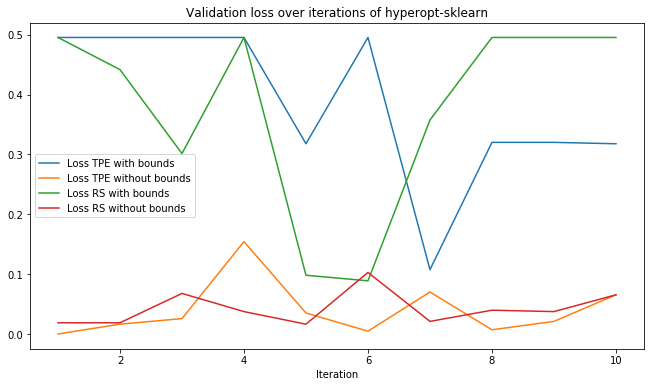

In [186]:
y_range = range(1, n_iter_search+1)
plt.figure(figsize=(11,6)) 
plt.title("Validation loss over iterations of hyperopt-sklearn")
plt.xlabel("Iteration")
plt.plot(y_range, [i['loss'] for i in estim.trials.results], label="Loss TPE with bounds")
plt.plot(y_range, [i['loss'] for i in estim_wo_bounds.trials.results], label="Loss TPE without bounds")
plt.plot(y_range, [i['loss'] for i in estim_rand.trials.results], label="Loss RS with bounds")
plt.plot(y_range, [i['loss'] for i in estim_rand_wo_bounds.trials.results], label="Loss RS without bounds")
plt.legend()
plt.savefig('img/validation_losses.png', format='png', dpi=600)
plt.show()

## Random search CV of hyperparameters with Random Forest Classificator

In [24]:
clf = RandomForestClassifier(random_state=42)

# parameters range for random search
param_dist = {"min_samples_split": randint(2, 1000),
              "min_samples_leaf": randint(1, 1000),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
               "n_estimators": randint(1, 3000)}

In [25]:
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search)

In [26]:
# list to store scores over loop evaluations of benchmark
rs_scores = list()

In [27]:
%%timeit -o -n 10
random_search.fit(X_train, y_train)

print("=====RESULTS======")
rs_score = random_search.score(X_test, y_test)
rs_scores.append(rs_score)
print(rs_score)
print(random_search.best_estimator_)

=====RESULTS======
0.9014218009478673
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=254, min_samples_split=284,
                       min_weight_fraction_leaf=0.0, n_estimators=1766,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
=====RESULTS======
0.943127962085308
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=121, min_samples_split=219,
                       min_weight_fraction_leaf=0.0, n_estimators=2459,
                       n_jobs=None, oob_score=False, r

=====RESULTS======
0.9402843601895735
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=31, min_samples_split=682,
                       min_weight_fraction_leaf=0.0, n_estimators=2749,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
=====RESULTS======
0.943127962085308
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=86, min_samples_split=430,
                       min_weight_fraction_leaf=0.0, n_estimators=1501,
                       n_jobs=None, oob_score=False, rand

=====RESULTS======
0.9023696682464455
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=219, min_samples_split=487,
                       min_weight_fraction_leaf=0.0, n_estimators=1937,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
=====RESULTS======
0.9421800947867298
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=97, min_samples_split=338,
                       min_weight_fraction_leaf=0.0, n_estimators=1963,
                       n_jobs=None, oob_score=False, r

=====RESULTS======
0.9469194312796209
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=40, min_samples_split=357,
                       min_weight_fraction_leaf=0.0, n_estimators=2165,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
=====RESULTS======
0.8701421800947867
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=338, min_samples_split=727,
                       min_weight_fraction_leaf=0.0, n_estimators=247,
                       n_jobs=None, oob_score=False, ra

=====RESULTS======
0.9554502369668246
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=26, min_samples_split=152,
                       min_weight_fraction_leaf=0.0, n_estimators=2606,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
=====RESULTS======
0.9459715639810427
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=65, min_samples_split=84,
                       min_weight_fraction_leaf=0.0, n_estimators=1594,
                       n_jobs=None, oob_score=False, rand

<TimeitResult : 47.7 s ± 2.51 s per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [28]:
with open('temp/rs_scores.txt', 'wb') as fp:
    pickle.dump(rs_scores, fp)

In [29]:
with open ('temp/rs_scores.txt', 'rb') as fp:
    rs_scores = pickle.load(fp)

In [23]:
runtime_rs = _

### Visualization of a tree from Random Forest

In [ ]:
tree = random_search.best_estimator_[0]
export_graphviz(tree, out_file = 'temp/tree_rs.dot', rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('temp/tree_rs.dot')
graph.write_png('img/tree_rs.png')

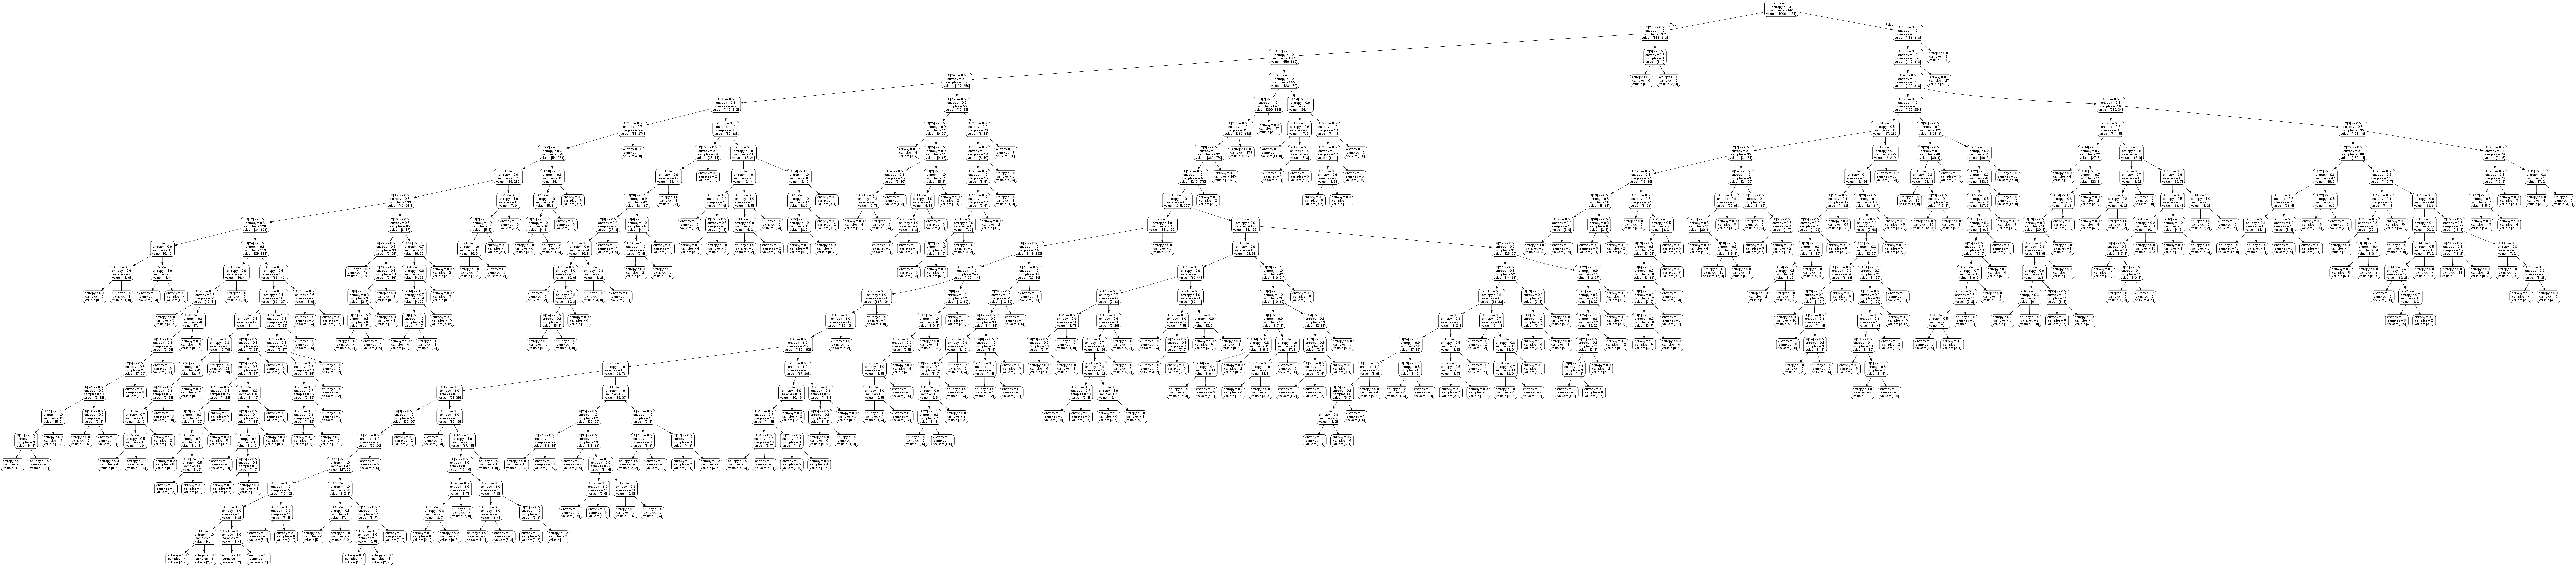

In [107]:
Image('img/tree_rs.png')

### Visualization of validation scores

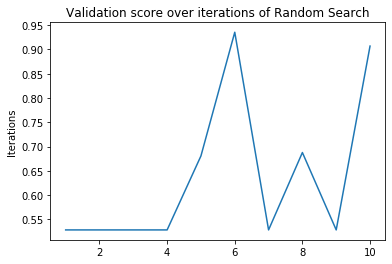

In [25]:
y_iter = range(1, n_iter_search+1)
test_scores = random_search.cv_results_[f'mean_test_score'][::-1]
plt.figure(2) 
plt.title("Validation score over iterations of Random Search")
plt.ylabel("Iterations")
plt.plot(y_iter, test_scores)
plt.show()

### Comparison of runtime

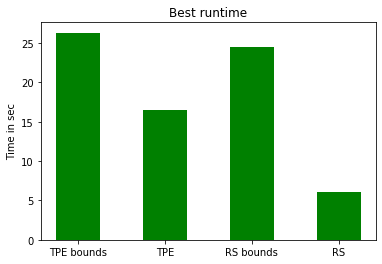

In [169]:
plt.figure()
plt.title("Best runtime")
plt.ylabel("Time in sec")
plt.bar(["TPE bounds", "TPE", "RS bounds", "RS"],
        [runtime_ho.best, runtime_ho_no_bounds.best, runtime_estim_rand.best, runtime_rand_wo_bounds.best], 
        width=0.5, color="g")
plt.show()

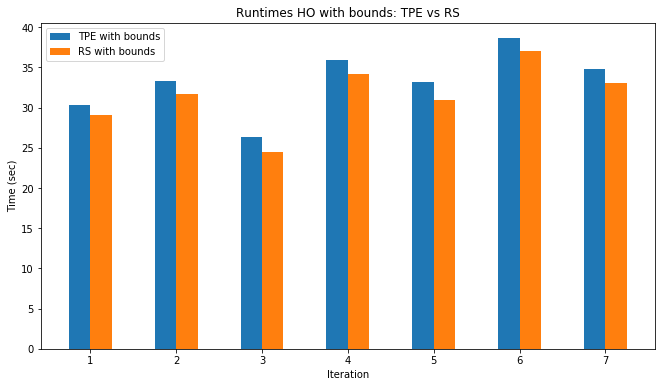

In [166]:
plt.figure(figsize=(11,6))
plt.title("Runtimes HO with bounds: TPE vs RS")

barWidth = 0.25

ind = np.arange(1, len(runtime_ho.all_runs)+1)

plt.bar(ind - barWidth/2, runtime_ho.all_runs, width=barWidth, label="TPE with bounds")
plt.bar(ind + barWidth/2, runtime_estim_rand.all_runs, width=barWidth, label="RS with bounds")

plt.xlabel('Iteration')
plt.ylabel('Time (sec)')

plt.legend()
plt.show()

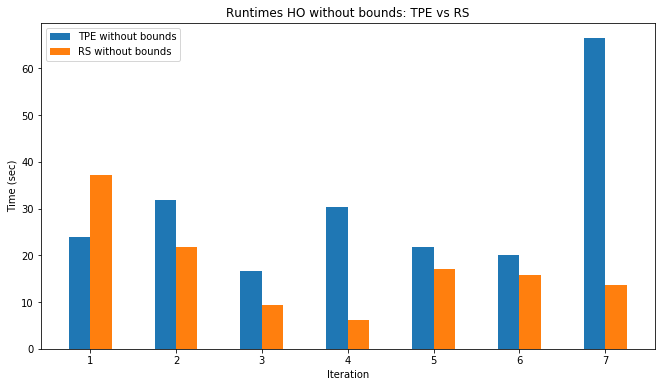

In [165]:
plt.figure(figsize=(11,6))
plt.title("Runtimes HO without bounds: TPE vs RS")

barWidth = 0.25

ind = np.arange(1, len(runtime_ho_no_bounds.all_runs)+1)

plt.bar(ind - barWidth/2, runtime_ho_no_bounds.all_runs, width=barWidth, label="TPE without bounds")
plt.bar(ind + barWidth/2, runtime_rand_wo_bounds.all_runs, width=barWidth, label="RS without bounds")

plt.xlabel('Iteration')
plt.ylabel('Time (sec)')

plt.legend()
plt.show()

In [27]:
def plot_scores(ho_scores, rs_scores):
    plt.figure()
    #plt.locator_params(nbins=len(ho_scores))
    plt.title("Scores of HO with TPE and RS using hyperopt-sklearn")
    plt.plot(range(1, len(ho_scores)+1), ho_scores, label="HO", c="b")
    plt.plot(range(1, len(rs_scores)+1), rs_scores, label="RS", c="g")
    plt.xlabel("Iterations")
    plt.ylabel("Scores")
    plt.legend()
    plt.savefig('img/scores1.png', format='png', dpi=600)
    plt.show()
#plot_scores(ho_scores, rs_scores)

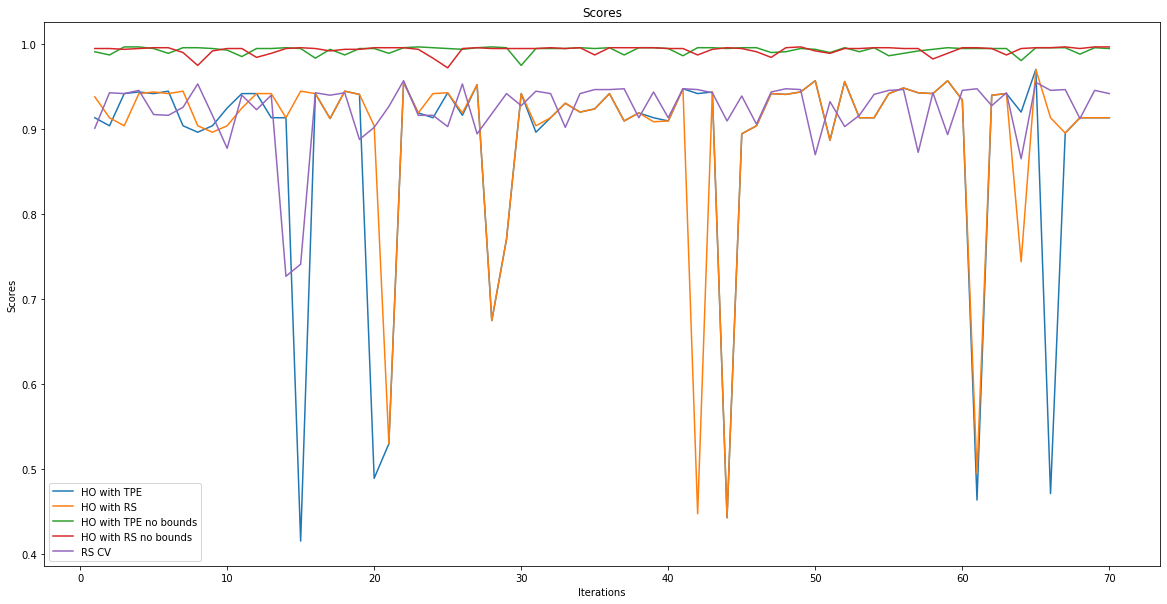

In [72]:
def plot_scores5(ho_scores, ho_scores2, ho_scores3, ho_scores4, rs_scores):
    plt.figure(figsize=(20,10))
    #plt.locator_params(nbins=len(ho_scores))
    plt.title("Scores")
    plt.plot(range(1, len(ho_scores)+1), ho_scores, label="HO with TPE")
    plt.plot(range(1, len(rs_scores)+1), ho_scores2, label="HO with RS")
    plt.plot(range(1, len(ho_scores2)+1), ho_scores3, label="HO with TPE no bounds")
    plt.plot(range(1, len(ho_scores2)+1), ho_scores4, label="HO with RS no bounds")
    plt.plot(range(1, len(ho_scores2)+1), rs_scores, label="RS CV")
    plt.xlabel("Iterations")
    plt.ylabel("Scores")
    plt.legend()
    plt.savefig('img/scores2.png', format='png', dpi=600)
    plt.show()
plot_scores5(ho_scores, ho_scores_rand, ho_scores_no_bounds, ho_scores_rand_wo_bounds, rs_scores)

## Dataset 2

### Load dataset

Link to dataset: https://archive.ics.uci.edu/ml/datasets/Census+Income

In [68]:
data2 = pd.read_csv("adult.data", names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                                                "occupation", "relationship", "race", "sex",
                                                "capital-gain", "capital-loss", "hours-per-week", 
                                                "native-country", "income"])
data2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [69]:
data2 = data2.drop(['education-num'], axis=1)

In [8]:
data2.describe()

,age,fnlwgt,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,99999.000000,4356.000000,99.000000


In [11]:
data2.shape

(32561, 14)

In [70]:
X2 = data2.loc[:, :'native-country']
y2 = data2.loc[:, 'income']

### Preprocessing of categorical columns

In [71]:
cat_cols = ["workclass", "education", "marital-status",
            "occupation", "relationship", "race", "sex",
             "native-country"]


le = LabelEncoder()
for col in cat_cols:
    X2[col] = le.fit_transform(X2[col])

ohe = OneHotEncoder(sparse=False, categorical_features=X2.columns.isin(cat_cols))
X2 = ohe.fit_transform(X2)

In [72]:
y2 = le.fit_transform(y2)
ohe = OneHotEncoder(sparse=False)
y2 = ohe.fit_transform(y2.reshape(-1, 1))

### Make train and test subsets

In [73]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

In [74]:
X2_train = np.array(X2_train)
X2_test = np.array(X2_test)

## HyperoptEstimator on TPE with Random Forest Classificator  

In [16]:
ho_scores_d2 = list()

In [37]:
#%%timeit -o

estim_wo_bounds.fit(X2_train, y2_train)
print("=====RESULTS======")
ho_score = estim_wo_bounds.score(X2_test, y2_test)
ho_scores_d2.append(ho_score)
print(ho_score)
print(estim_wo_bounds.best_model())

100%|██████████| 1/1 [00:02<00:00,  2.02s/it, best loss: 0.14095805638322256]
=====RESULTS======
0.8631118555741671
{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.13914150657494018,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=14,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1034, n_jobs=1, oob_score=False,
                       random_state=0, verbose=False, warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)),), 'ex_preprocs': ()}


In [36]:
runtime_ho2 = _
runtime_ho2

<TimeitResult : 6min 32s ± 3min 54s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [18]:
save_res(ho_scores_d2, "temp/ho_scores_d2.txt")

In [19]:
ho_scores_d2 = read_res("temp/ho_scores_d2.txt")

## HyperoptEstimator on Random Search with Random Forest Classificator

In [20]:
rs_scores_d2 = list()

In [39]:
%%timeit -o
estim_rand_wo_bounds.fit(X2_train, y2_train)
print("=====RESULTS======")
ho_score = estim_rand_wo_bounds.score(X2_test, y2_test)
rs_scores_d2.append(ho_score)
print(ho_score)
print(estim_rand_wo_bounds.best_model())

100%|██████████| 1/1 [00:30<00:00, 30.89s/it, best loss: 0.14095805638322256]
=====RESULTS======
0.862925739810162
{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=11, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2209,
                       n_jobs=1, oob_score=False, random_state=2, verbose=False,
                       warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(0.0, 1.0)),), 'ex_preprocs': ()}
100%|██████████| 1/1 [01:37<00:00, 97.67s/it, best loss: 0.13774925509970204]
=====RESULTS======
0.8646007816862088
{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
        

100%|██████████| 1/1 [01:01<00:00, 61.09s/it, best loss: 0.13408205363282144]
=====RESULTS======
0.8659035920342453
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=178, n_jobs=1,
                       oob_score=False, random_state=1, verbose=False,
                       warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(0.0, 1.0)),), 'ex_preprocs': ()}
100%|██████████| 1/1 [00:05<00:00,  5.51s/it, best loss: 0.14439605775842312]
=====RESULTS======
0.8580867299460264
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
       

<TimeitResult : 9min 13s ± 5min 48s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [40]:
runtime_rs2 = _
runtime_rs2

<TimeitResult : 9min 13s ± 5min 48s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [23]:
save_res(rs_scores_d2, "temp/rs_scores_d2.txt")

In [24]:
rs_scores_d2 = read_res("temp/rs_scores_d2.txt")

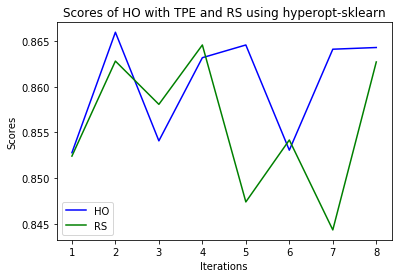

In [29]:
plot_scores(ho_scores_d2, rs_scores_d2)

# Scikit-optimize: Baysian Optimization with GP and Random Search

## Install requirements

In [44]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize, dummy_minimize, forest_minimize
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from functools import partial

## Random Forest Classificator

## Initilize classifier and optimization on dataset 1

In [170]:
clf = RandomForestClassifier(random_state=42)

In [45]:
# The list of hyper-parameters we want to optimize. For each one define the bounds,
# the corresponding scikit-learn parameter name
space  = [Integer(2, 1000, name='min_samples_split'),
          Integer(1, 1000, name='min_samples_leaf'),
          Categorical([True, False], name="bootstrap"),
          Categorical(["gini", "entropy"], name="criterion"),
          Integer(1, 3000, name='n_estimators')]

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)

    return -np.mean(cross_val_score(clf, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [57]:
#%%timeit -o
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
print("Best score=%.4f" % res_gp.fun)

Best score=0.0466


In [55]:
runtime_res_gp = _
runtime_res_gp

<TimeitResult : 3min 16s ± 1.69 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [61]:
print("""Best parameters:
- min_samples_split=%d
- min_samples_leaf=%d
- bootstrap=%d
- criterion=%s
- n_estimators=%d""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3], res_gp.x[4]))

Best parameters:
- min_samples_split=2
- min_samples_leaf=1
- bootstrap=0
- criterion=entropy
- n_estimators=1983


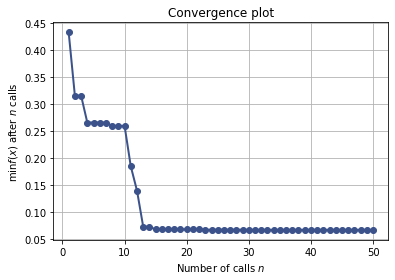

In [159]:
plot_convergence(res_gp)

In [65]:
#%%timeit -o
res_rs = dummy_minimize(objective, space, n_calls=50, random_state=0)
"Best score=%.4f" % res_rs.fun

'Best score=0.0826'

In [63]:
runtime_res_rs = _
runtime_res_rs

<TimeitResult : 1min 37s ± 266 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [66]:
print("""Best parameters:
- min_samples_split=%d
- min_samples_leaf=%d
- bootstrap=%d
- criterion=%s
- n_estimators=%d""" % (res_rs.x[0], res_rs.x[1], res_rs.x[2], res_rs.x[3], res_rs.x[4]))

Best parameters:
- min_samples_split=425
- min_samples_leaf=62
- bootstrap=0
- criterion=gini
- n_estimators=1955


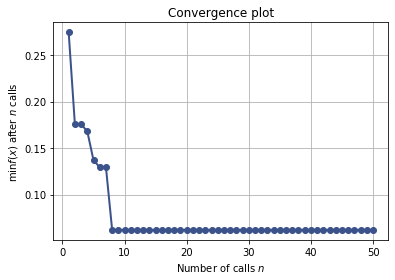

In [57]:
plot_convergence(res_rs)

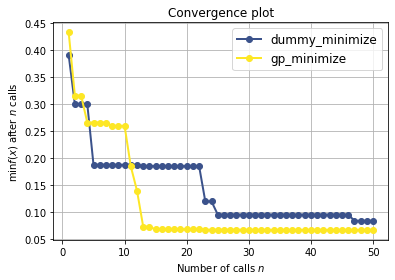

In [165]:
plot = plot_convergence(("dummy_minimize", res_rs),
                        ("gp_minimize", res_gp))

plot.legend(loc="best", prop={'size': 12}, numpoints=1);

### Dataset 2

In [77]:
@use_named_args(space)
def objective2(**params):
    clf.set_params(**params)

    return -np.mean(cross_val_score(clf, X2, y2, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

In [82]:
#%%timeit -o
res_gp2 = gp_minimize(objective2, space, n_calls=30, random_state=0)
print("Best score=%.4f" % res_gp2.fun)

Best score=0.1356


In [80]:
runtime_res_gp = _
runtime_res_gp

<TimeitResult : 30min 17s ± 15.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [83]:
print("""Best parameters:
- min_samples_split=%d
- min_samples_leaf=%d
- bootstrap=%d
- criterion=%s
- n_estimators=%d""" % (res_gp2.x[0], res_gp2.x[1], res_gp2.x[2], res_gp2.x[3], res_gp2.x[4]))

Best parameters:
- min_samples_split=3
- min_samples_leaf=3
- bootstrap=1
- criterion=gini
- n_estimators=292


In [87]:
%%timeit -o
res_rs2 = dummy_minimize(objective2, space, n_calls=30, random_state=0)
"Best score=%.4f" % res_rs2.fun

14min 45s ± 3.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 14min 45s ± 3.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [85]:
print("""Best parameters:
- min_samples_split=%d
- min_samples_leaf=%d
- bootstrap=%d
- criterion=%s
- n_estimators=%d""" % (res_rs2.x[0], res_rs2.x[1], res_rs2.x[2], res_rs2.x[3], res_rs2.x[4]))

Best parameters:
- min_samples_split=784
- min_samples_leaf=42
- bootstrap=0
- criterion=gini
- n_estimators=87


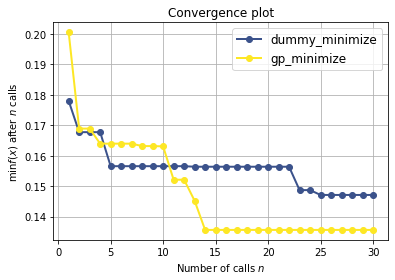

In [86]:
plot = plot_convergence(("dummy_minimize", res_rs2),
                        ("gp_minimize", res_gp2))

plot.legend(loc="best", prop={'size': 12}, numpoints=1);

# SVM

In [171]:
from sklearn import svm
from sklearn.datasets import load_wine

## Load wine dataset

In [59]:
wine = load_wine()

In [60]:
x = wine.data
y = wine.target

## Split data into train and test set (80-20)

In [61]:
test_size = int(0.2 * len(y))
np.random.seed(42)
indices = np.random.permutation(len(x))
x_train = x[indices[:-test_size]]
y_train = y[indices[:-test_size]]
x_test = x[indices[-test_size:]]
y_test = y[indices[-test_size:]]

## Define objective functions and optimize with scikit-optimize

In [62]:
#dimensions = [(1e-10,20-1e-10,"uniform"),["linear","sigmoid","poly","rbf"],(1e-10,20-1e-10,"uniform")]

# Hyperparameter space
dimensions = [Real(0+1e-10,10-1e-10,"uniform",name="C"),Real(0+1e-10,10-1e-10,"uniform",name="gamma"),Categorical(["rbf","poly","linear","sigmoid"],name="kernel")]

# Objective Function (test-score)
@use_named_args(dimensions)
def f(**params):
    clf = svm.SVC(**params)
    #clf.fit(x_train, y_train)
    #return -clf.score(x_test,y_test)
    return -cross_val_score(clf,x,y,cv=5).mean()

### Run optimization with different surrogate models:
# (1) Gaussian Process
# (2) Random Forest
# (3) No model (random search)

gp_res = gp_minimize(f, dimensions=dimensions, acq_func="EI", n_calls=50, n_random_starts=10, n_jobs=-1) 
rf_res = forest_minimize(f, dimensions=dimensions, acq_func="EI", n_calls=50, base_estimator="RF",n_random_starts=10, n_jobs=-1)
dummy_res = dummy_minimize(f, dimensions=dimensions, n_calls=50)

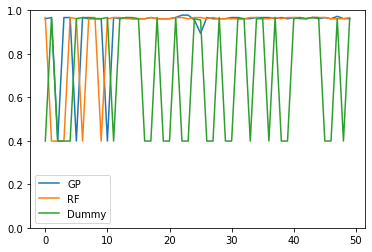

In [63]:
# Plot results
plt.plot(list(range(len(gp_res.func_vals))),-gp_res.func_vals, label="GP")
plt.plot(list(range(len(rf_res.func_vals))),-rf_res.func_vals, label="RF")
plt.plot(list(range(len(dummy_res.func_vals))),-dummy_res.func_vals, label="Dummy")
plt.ylim(0,1)
plt.legend()

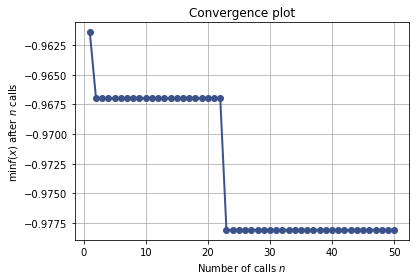

In [64]:
plot_convergence(gp_res)

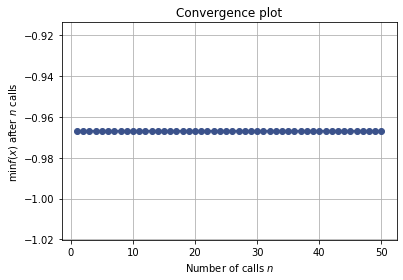

In [65]:
plot_convergence(rf_res)

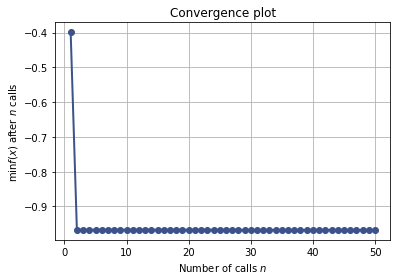

In [66]:
plot_convergence(dummy_res)